# Práctica 5 — Ajedrez

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import os

In [220]:
# Cargamos subconjunto del dataset
df = pd.read_csv('lichess_games.csv', nrows=10000)
df.head(10).to_latex('outputs/original.tex', index=False)

In [221]:
# 2. Eliminamos columnas innecesarias
df = df.drop(columns=['Site', 'White', 'Black', 'Opening'])

# 3. Preprocesamiento de Elo (asumir "?" como 0)
df['WhiteElo'] = pd.to_numeric(df['WhiteElo'].replace('?', '0'))
df['BlackElo'] = pd.to_numeric(df['BlackElo'].replace('?', '0'))

# Añadimos atributos derivados
df['GameElo'] = np.ceil((df['WhiteElo'] + df['BlackElo']) / 2)
df['EloDiff'] = df['WhiteElo'] - df['BlackElo']

# 4. Codificación de variables categóricas
le = LabelEncoder()
columnas_a_codificar = ['Result', 'ECO', 'Termination', 'TimeControl']
for col in columnas_a_codificar:
    df[col] = le.fit_transform(df[col].astype(str))

y = df['Result'].values
original = df.drop(columns=['Result'])

print(original.head(10))
print(original.shape)
print(y)

original.head(10).to_latex('outputs/procesado.tex', index=False)

   WhiteElo  BlackElo  TimeControl  ECO  Termination  MovesCount  GameElo  \
0      1247      1218           17  152            1          15   1233.0   
1      1577      1593           17   75            2          52   1585.0   
2      1043      1000           17  204            1          44   1022.0   
3      2015      2028           17   76            1          29   2022.0   
4      2139      2145           17   73            1          56   2142.0   
5      1756      1737           17   69            1          21   1747.0   
6      1638      1696           17   35            2          45   1667.0   
7      1841      1825           17  135            1          45   1833.0   
8      1699      1713           17  161            1          29   1706.0   
9      1496      1575           17  147            1          24   1536.0   

   EloDiff  
0       29  
1      -16  
2       43  
3      -13  
4       -6  
5       19  
6      -58  
7       16  
8      -14  
9      -79  
(10000, 8

In [194]:
# Tomamos una muestra para no ralentizar el gráfico
# sns.pairplot(original.sample(500), hue='Result', palette='viridis')
# plt.suptitle("Visualización Conjunto Original (Muestra)", y=1.02)
# plt.show()

   WhiteElo  BlackElo  TimeControl       ECO  Termination  MovesCount  \
0 -1.064022 -1.136124    -1.082633  0.620946    -0.712426   -1.219267   
1 -0.223953 -0.180823    -1.082633 -0.434230     1.373129    1.246942   
2 -1.583338 -1.691472    -1.082633  1.333533    -0.712426    0.713708   
3  0.891049  0.927325    -1.082633 -0.420526    -0.712426   -0.286107   
4  1.206711  1.225379    -1.082633 -0.461637    -0.712426    1.513559   
5  0.231721  0.186012    -1.082633 -0.516451    -0.712426   -0.819341   
6 -0.068667  0.081566    -1.082633 -0.982373     1.373129    0.780362   
7  0.448103  0.410189    -1.082633  0.387986    -0.712426    0.780362   
8  0.086619  0.124873    -1.082633  0.744279    -0.712426   -0.286107   
9 -0.430151 -0.226678    -1.082633  0.552429    -0.712426   -0.619378   

    GameElo   EloDiff  
0 -1.108589  0.278118  
1 -0.204722 -0.168738  
2 -1.650395  0.417140  
3  0.917407 -0.138948  
4  1.225543 -0.069437  
5  0.211262  0.178817  
6  0.005837 -0.585804  
7  0

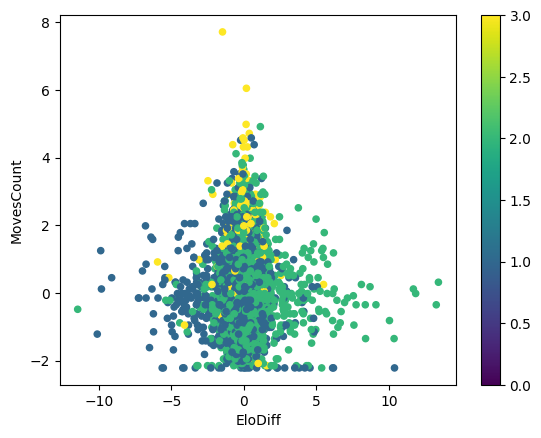

In [227]:
# Obtenemos el conjunto de datos estandarizado
standarized = StandardScaler().fit_transform(original)

standarized = pd.DataFrame(standarized, columns=original.columns)
standarized.plot.scatter(x='EloDiff', y='MovesCount', c=y, cmap='viridis')

print(standarized.head(10))

   WhiteElo  BlackElo  TimeControl       ECO  Termination  MovesCount  \
0  0.291388  0.292505     0.180851  0.500000     0.333333    0.100671   
1  0.413883  0.429616     0.180851  0.246711     0.666667    0.348993   
2  0.215664  0.212797     0.180851  0.671053     0.333333    0.295302   
3  0.576466  0.588665     0.180851  0.250000     0.333333    0.194631   
4  0.622494  0.631444     0.180851  0.240132     0.333333    0.375839   
5  0.480327  0.482267     0.180851  0.226974     0.333333    0.140940   
6  0.436526  0.467276     0.180851  0.115132     0.666667    0.302013   
7  0.511878  0.514442     0.180851  0.444079     0.333333    0.302013   
8  0.459169  0.473492     0.180851  0.529605     0.333333    0.194631   
9  0.383816  0.423035     0.180851  0.483553     0.333333    0.161074   

    GameElo   EloDiff  
0  0.277986  0.472067  
1  0.410218  0.454110  
2  0.198723  0.477654  
3  0.574380  0.455307  
4  0.619459  0.458101  
5  0.471074  0.468077  
6  0.441022  0.437350  
7  0

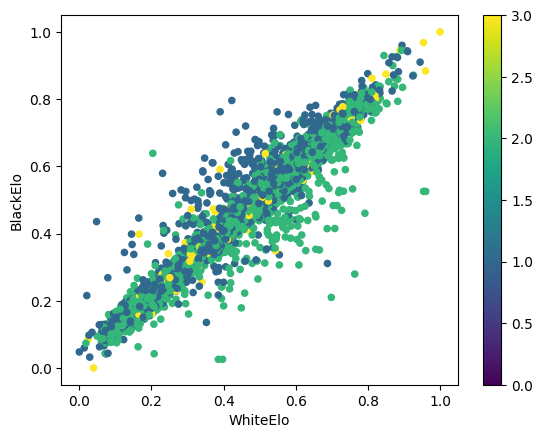

In [228]:
normalized = MinMaxScaler().fit_transform(original)

normalized = pd.DataFrame(normalized, columns=original.columns)
normalized.plot.scatter(x='WhiteElo', y='BlackElo', c=y, cmap='viridis')

print(normalized.head(10))

In [ ]:
pca95 = PCA(n_components=0.95)
pca80 = PCA(n_components=0.8)

# PCA 0.95
original_pca95 = pd.DataFrame(pca95.fit_transform(original), columns=[f'PC{i+1}' for i in range(pca95.n_components_)])
standarized_pca95 = pd.DataFrame(pca95.fit_transform(standarized), columns=[f'PC{i+1}' for i in range(pca95.n_components_)])
normalized_pca95 = pd.DataFrame(pca95.fit_transform(normalized), columns=[f'PC{i+1}' for i in range(pca95.n_components_)])


# PCA 0.8
original_pca80 = pd.DataFrame(pca80.fit_transform(original), columns=[f'PC{i+1}' for i in range(pca80.n_components_)])
standarized_pca80 = pd.DataFrame(pca80.fit_transform(standarized), columns=[f'PC{i+1}' for i in range(pca80.n_components_)])
normalized_pca80 = pd.DataFrame(pca80.fit_transform(normalized), columns=[f'PC{i+1}' for i in range(pca80.n_components_)])

dict_pca = {
    'Original PCA 95%': original_pca95.shape[1],
    'Standarized PCA 95%': standarized_pca95.shape[1],
    'Normalized PCA 95%': normalized_pca95.shape[1],
    'Original PCA 80%': original_pca80.shape[1],
    'Standarized PCA 80%': standarized_pca80.shape[1],
    'Normalized PCA 80%': normalized_pca80.shape[1]
}

for key, value in dict_pca.items():
    print(f"{key}: {value} components")

try:
    os.mkdir('outputs')
except FileExistsError:
    pass

pd.DataFrame(
    list(dict_pca.items()), 
    columns=['PCA Type', 'Number of Components']
).to_latex('outputs/pca_components.tex', index=False)

Original PCA 95%: 1 components
Standarized PCA 95%: 6 components
Normalized PCA 95%: 5 components
Original PCA 80%: 1 components
Standarized PCA 80%: 5 components
Normalized PCA 80%: 3 components


In [226]:
def generate_train_test_set(kf, data, name):
    try:
        os.mkdir(path=name)
    except FileExistsError:
        pass

    for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
        
        X_train = data.iloc[train_idx]
        X_test = data.iloc[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]

        training = pd.DataFrame(
            np.concatenate((X_train, y_train.reshape(y_train.shape[0], 1)), axis=1)
        )
        test = pd.DataFrame(
            np.concatenate((X_test, y_test.reshape(y_test.shape[0], 1)), axis=1)
        )

        training.to_csv(f"{name}/training{fold + 1}_{name}.csv", index=False)
        test.to_csv(f"{name}/test{fold + 1}_{name}.csv", index=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Diccionario con todos los conjuntos de datos para iterar
datasets = {
    "original": original,
    "standarized": standarized,
    "normalized": normalized,
    "original_pca_95": original_pca95,
    "original_pca_80": original_pca80,
    "standarized_pca_95": standarized_pca95,
    "standarized_pca_80": standarized_pca80,
    "normalized_pca_95": normalized_pca95,
    "normalized_pca_80": normalized_pca80
}

for nombre, ds in datasets.items():
    generate_train_test_set(kf, ds, nombre)